In [1]:
! pip install kaggle
! mkdir ~/.kaggle
! mv kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

! kaggle datasets download -d thedevastator/jobs-dataset-from-glassdoor
! unzip jobs-dataset-from-glassdoor.zip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  0% 0.00/3.23M [00:00<?, ?B/s]
100% 3.23M/3.23M [00:00<00:00, 214MB/s]
Archive:  jobs-dataset-from-glassdoor.zip
  inflating: eda_data.csv            
  inflating: glassdoor_jobs.csv      
  inflating: salary_data_cleaned.csv  


In [2]:
import pandas as pd

dataset = pd.read_csv("salary_data_cleaned.csv")
dataset.head()

,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Headquarters,Size,Founded,Type of ownership,...,avg_salary,company_txt,job_state,same_state,age,python_yn,R_yn,spark,aws,excel
0,Data Scientist,$53K-$91K (Glassdoor est.),"Data Scientist\nLocation: Albuquerque, NM\nEdu...",3.8,Tecolote Research\n3.8,"Albuquerque, NM","Goleta, CA",501 to 1000 employees,1973,Company - Private,...,72.0,Tecolote Research\n,NM,0,47,1,0,0,0,1
1,Healthcare Data Scientist,$63K-$112K (Glassdoor est.),What You Will Do:\n\nI. General Summary\n\nThe...,3.4,University of Maryland Medical System\n3.4,"Linthicum, MD","Baltimore, MD",10000+ employees,1984,Other Organization,...,87.5,University of Maryland Medical System\n,MD,0,36,1,0,0,0,0
2,Data Scientist,$80K-$90K (Glassdoor est.),"KnowBe4, Inc. is a high growth information sec...",4.8,KnowBe4\n4.8,"Clearwater, FL","Clearwater, FL",501 to 1000 employees,2010,Company - Private,...,85.0,KnowBe4\n,FL,1,10,1,0,1,0,1
3,Data Scientist,$56K-$97K (Glassdoor est.),*Organization and Job ID**\nJob ID: 310709\n\n...,3.8,PNNL\n3.8,"Richland, WA","Richland, WA",1001 to 5000 employees,1965,Government,...,76.5,PNNL\n,WA,1,55,1,0,0,0,0
4,Data Scientist,$86K-$143K (Glassdoor est.),Data Scientist\nAffinity Solutions / Marketing...,2.9,Affinity Solutions\n2.9,"New York, NY","New York, NY",51 to 200 employees,1998,Company - Private,...,114.5,Affinity Solutions\n,NY,1,22,1,0,0,0,1


In [3]:
# dataset = dataset.drop(['Job Description','Salary Estimate', 'Headquarters', 'Size', 'Revenue', 'Competitors', 'Company Name'], axis=1, inplace=True)
# dataset.columns


dataset.drop(['Salary Estimate', 'Job Description', 'Rating','Company Name', 'Headquarters', 'Size','Type of ownership', 'Industry', 'Sector', 'Revenue', 'Competitors','hourly', 'employer_provided', 'min_salary', 'max_salary','company_txt', 'job_state', 'same_state', 'age', 'python_yn', 'R_yn','spark', 'aws', 'excel'], axis=1, inplace=True)

dataset.columns

Index(['Job Title', 'Location', 'Founded', 'avg_salary'], dtype='object')

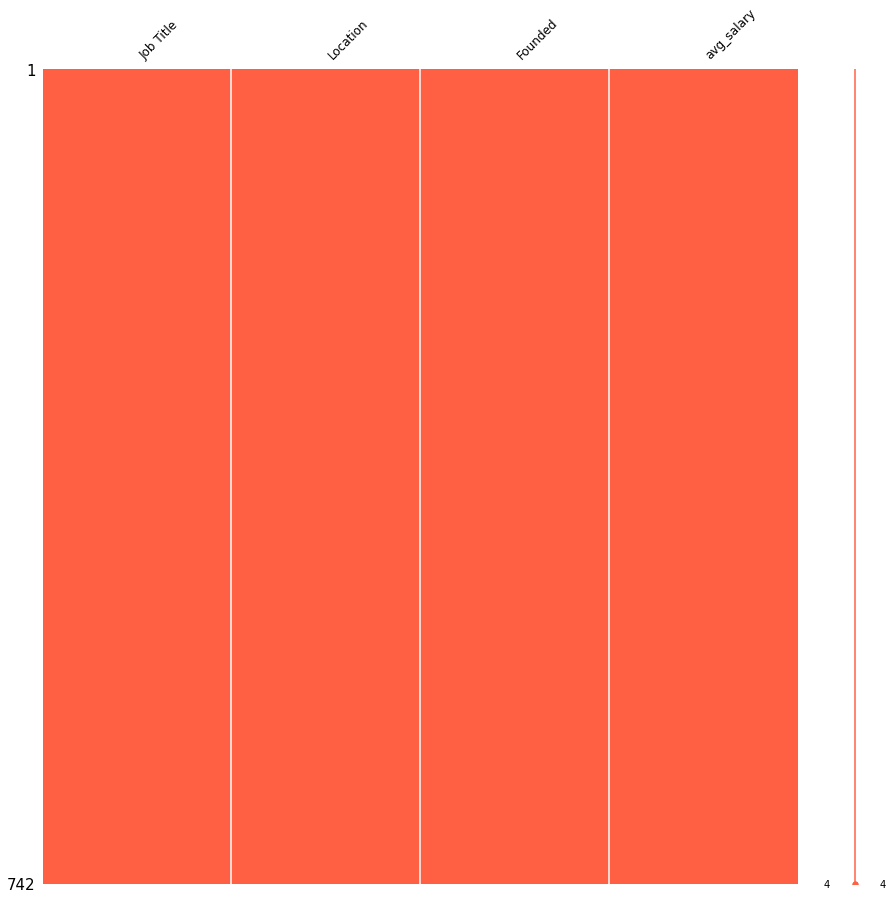

In [4]:
import missingno

missingno.matrix(dataset, figsize=(15,15), fontsize=12, color=(1, 0.38, 0.27));
dataset = dataset.dropna(subset=['Job Title', 'Location', 'Founded', 'avg_salary'])

In [5]:
import numpy as np

X = dataset.copy()
y = X.pop('avg_salary')

In [6]:
_v, _l = np.unique(X.iloc[:,0].values, return_inverse=True)
X['Job Title'] = _l

In [7]:
_v, _l = np.unique(X.iloc[:,2].values, return_inverse=True)
X['Location'] = _l

In [8]:
X.head()

,Job Title,Location,Founded
0,69,56,1973
1,106,67,1984
2,69,93,2010
3,69,48,1965
4,69,81,1998


In [9]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

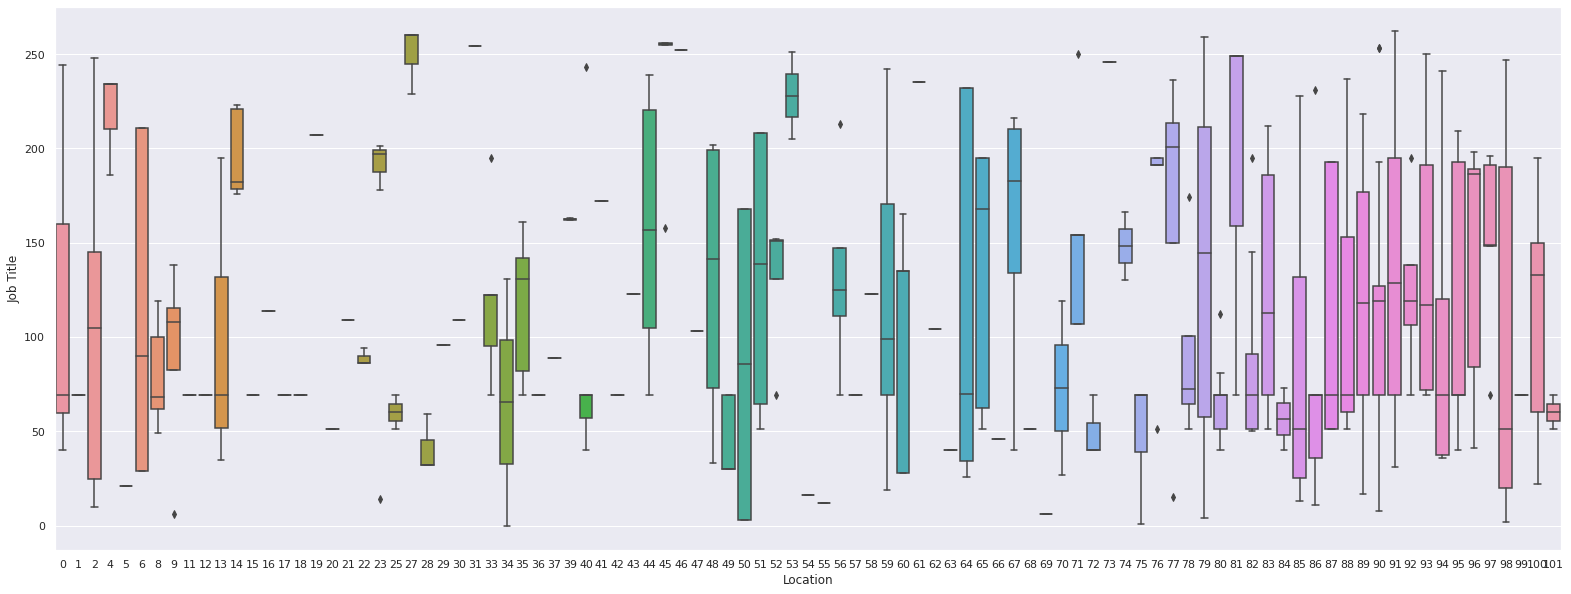

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(rc={'figure.figsize':(27,10)})

sns.boxplot( x=x_train["Location"], y=x_train["Job Title"] )

In [11]:
# нормирование входов (разница в величинах измеерний)
mean = x_train.mean(axis=0)
x_train -= mean

std = x_train.std(axis=0)
x_train /= std

def norm(x):
  return (x - mean) / std

x_train = norm(x_train)
x_test = norm(x_test)

In [12]:
#нормирование ответов (из-за сигмоида)
min_y = y_train.min()
max_y = y_train.max() - min_y
y_train = (y_train - min_y) / max_y
y_test = (y_test - min_y) / max_y

In [13]:
import keras
from keras.datasets import boston_housing
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization

model = Sequential()
model.add(BatchNormalization()),
model.add(Dense(3, activation='relu', input_shape=(x_train.shape[1],)))
model.add(Dense(3, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='mse', metrics=['mae']) # средне-квадратичная ошибка | средний модуль ошибки

In [14]:
early_stopping = keras.callbacks.EarlyStopping(
    patience=10,
    min_delta=0.001,
    restore_best_weights=True,
)


history = model.fit(x_train, y_train, epochs=100, validation_split=0.1,callbacks=[early_stopping])

Epoch 1/100
15/15 [==============================] - 1s 16ms/step - loss: 0.0672 - mae: 0.2200 - val_loss: 0.1266 - val_mae: 0.3270
Epoch 2/100
15/15 [==============================] - 0s 4ms/step - loss: 0.0599 - mae: 0.2064 - val_loss: 0.0990 - val_mae: 0.2839
Epoch 3/100
15/15 [==============================] - 0s 5ms/step - loss: 0.0545 - mae: 0.1970 - val_loss: 0.0778 - val_mae: 0.2478
Epoch 4/100
15/15 [==============================] - 0s 4ms/step - loss: 0.0500 - mae: 0.1877 - val_loss: 0.0624 - val_mae: 0.2191
Epoch 5/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0462 - mae: 0.1795 - val_loss: 0.0506 - val_mae: 0.1942
Epoch 6/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0429 - mae: 0.1717 - val_loss: 0.0424 - val_mae: 0.1762
Epoch 7/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0401 - mae: 0.1659 - val_loss: 0.0364 - val_mae: 0.1614
Epoch 8/100
15/15 [==============================] - 0s 5ms/step - loss: 0.0378 - 

Best Validation Loss: 0.0276
Best Validation Accuracy: 0.3270


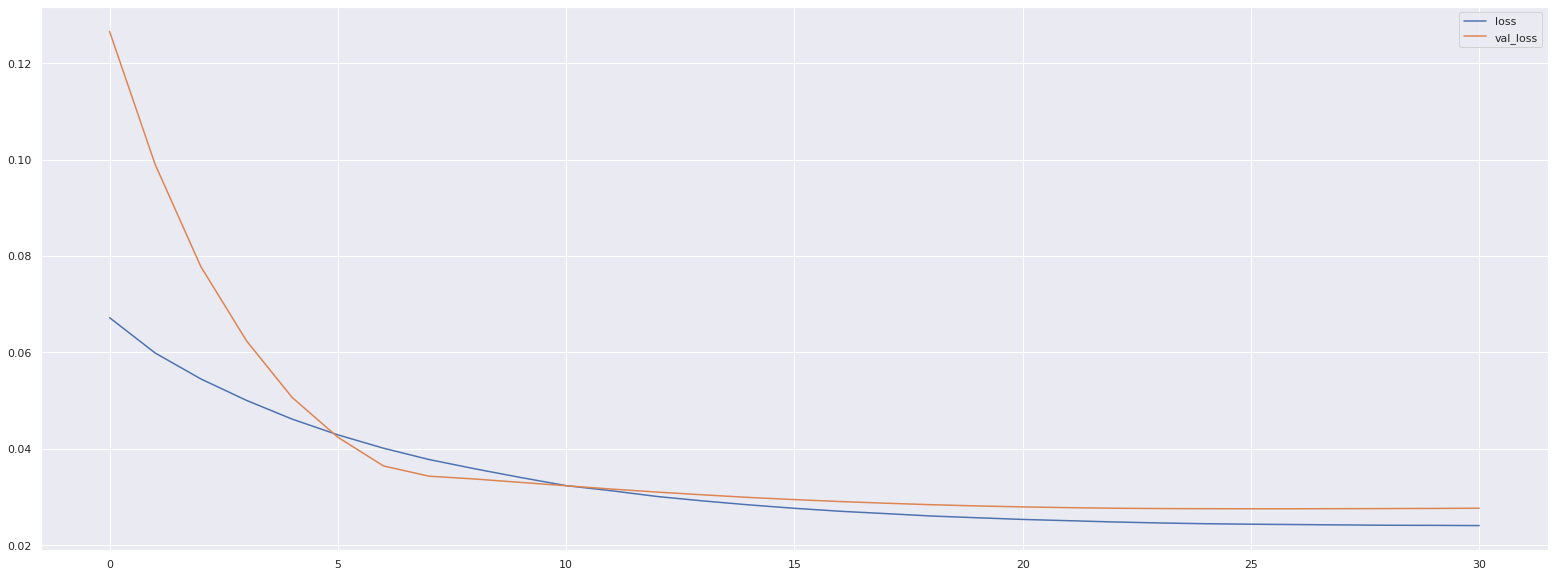

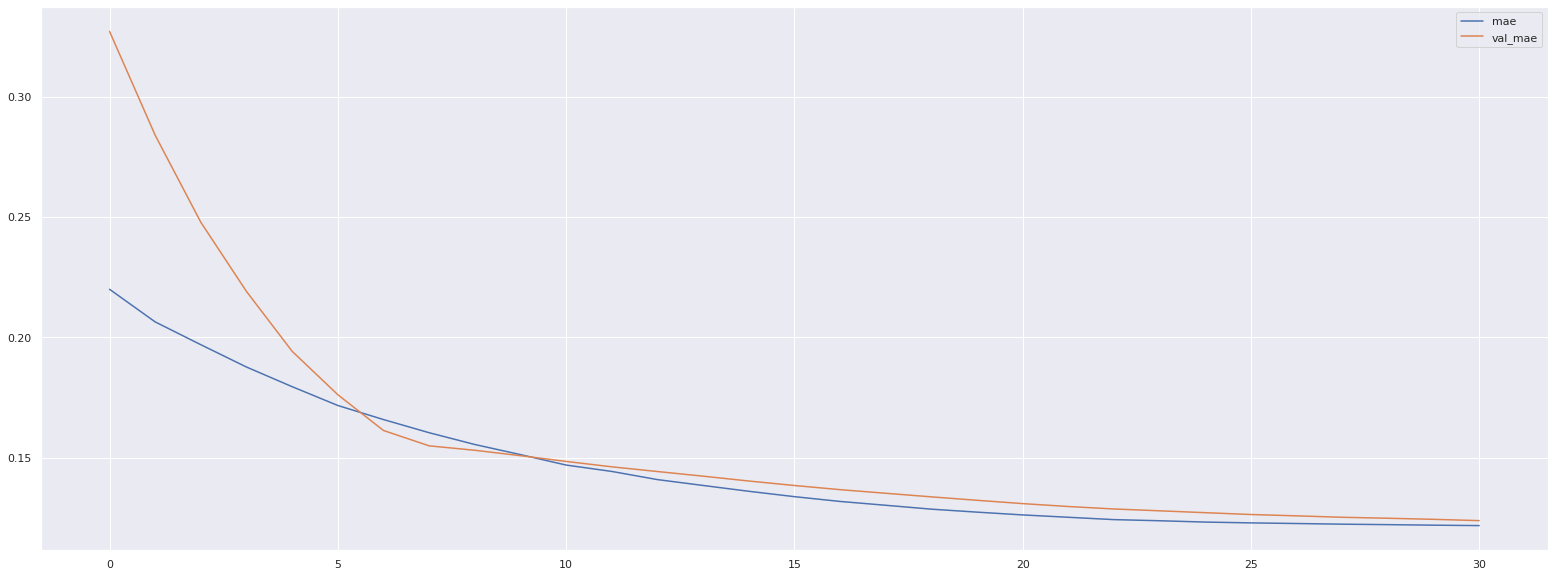

In [15]:
history_df = pd.DataFrame(history.history)
# Start the plot at epoch 5
history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['mae', 'val_mae']].plot()

print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}")\
      .format(history_df['val_loss'].min(), 
              history_df['val_mae'].max()))

In [16]:
df = pd.DataFrame({'Job Title': [69], 'Location': [93], 'Founded': [2018]})
df = norm(df)
pred = model.predict(df)
pred = pred * max_y + min_y 
print(pred)

1/1 [==============================] - 0s 93ms/step
[[244.0434]]
